In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

In [2]:
from tensorflow.examples.tutorials.mnist import input_data

In [3]:
mnist = input_data.read_data_sets('../../MNIST_data', one_hot=True)
# set the min batch size
mb_size = 64
# the number of samples to take from a random distribution
Z_dim = 100

# The number of training examples
X_dim = mnist.train.images.shape[1]
y_dim = mnist.train.labels.shape[1]

# The size of hidden layer
h_dim = 128

# Set the initial cost to zero
c = 0

# Set the learning rate
lr = 1e-3

Extracting ../../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../../MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
# Lets define the 'Xavier Initialization function'
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / np.sqrt(in_dim / 2.)
    return Variable(torch.randn(*size) * xavier_stddev, requires_grad=True)

### Define the models

#### Generator Network

In [5]:
#Generator Network
class Generator(nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        
        self.main = nn.Sequential(
            nn.Linear(Z_dim, h_dim),
            nn.ReLU(True),
            nn.Linear(h_dim, X_dim),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        output = self.main(x)
        
        return output

#### Discriminator Network

In [6]:
#Discriminator Network
class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.main = nn.Sequential(
            nn.Linear(X_dim, h_dim),
            nn.ReLU(True),
            nn.Linear(h_dim, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        output = self.main(x)
        
        return output

In [7]:
#Get instance of both classes
G = Generator()
D = Discriminator()

In [8]:
# Get parameters
G_params = G.parameters()
D_params = D.parameters()

In [9]:
# Reset gradients for Generator and Discriminator
def reset_grad():
    G.zero_grad()
    D.zero_grad()

In [10]:
# Define loss
criterion = nn.MSELoss()

# Declare the optimizers for generator
G_solver = optim.Adam(G_params, lr=1e-3)

# Declare the optimizers for discriminator
D_solver = optim.Adam(D_params, lr=1e-3)


# The targets for the discriminator.
# Zeros for the samples coming from generator and one for the data coming from sample space
ones_label = Variable(torch.ones(mb_size))
zeros_label = Variable(torch.zeros(mb_size))

In [11]:
gen_loss=[]
dis_loss=[]

for it in range(100000):
    # Sample data
    z = Variable(torch.randn(mb_size, Z_dim))
    X, _ = mnist.train.next_batch(mb_size)
    
    #The iputs should be a torch tensor
    X = Variable(torch.from_numpy(X))
    
    # Dicriminator forward-loss-backward-update
    G_sample = G(z)
    D_real = D(X)
    D_fake = D(G_sample)

    D_loss_real = criterion(D_real, ones_label)
    D_loss_fake = criterion(D_fake, zeros_label)
    D_loss = D_loss_real + D_loss_fake

    D_loss.backward()
    D_solver.step()

    # Housekeeping - reset gradient
    reset_grad()

    # Generator forward-loss-backward-update
    z = Variable(torch.randn(mb_size, Z_dim))
    G_sample = G(z)
    D_fake = D(G_sample)

    G_loss = criterion(D_fake, ones_label)

    G_loss.backward()
    G_solver.step()

    # Housekeeping - reset gradient
    reset_grad()

    # Print and plot every now and then
    if it % 1000 == 0:
        print('Iter-{}; D_loss: {}; G_loss: {}'.format(it, D_loss.data.numpy(), G_loss.data.numpy()))
        dis_loss.append(D_loss.data.numpy())
        gen_loss.append(G_loss.data.numpy())

        samples = G(z).data.numpy()[:16]

        fig = plt.figure(figsize=(4, 4))
        gs = gridspec.GridSpec(4, 4)
        gs.update(wspace=0.05, hspace=0.05)

        for i, sample in enumerate(samples):
            ax = plt.subplot(gs[i])
            plt.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

        plt.savefig('out-pytorch-gan/{}.png'.format(str(c).zfill(3)), bbox_inches='tight')
        c += 1
        plt.close(fig)

Iter-0; D_loss: [ 0.48657152]; G_loss: [ 0.53019524]
Iter-1000; D_loss: [ 0.02138289]; G_loss: [ 0.93806458]
Iter-2000; D_loss: [ 0.01303946]; G_loss: [ 0.90362054]
Iter-3000; D_loss: [ 0.02095347]; G_loss: [ 0.95513052]
Iter-4000; D_loss: [ 0.05892196]; G_loss: [ 0.87585598]
Iter-5000; D_loss: [ 0.04449201]; G_loss: [ 0.95240372]
Iter-6000; D_loss: [ 0.0722617]; G_loss: [ 0.79282206]
Iter-7000; D_loss: [ 0.13460487]; G_loss: [ 0.82863653]
Iter-8000; D_loss: [ 0.0828648]; G_loss: [ 0.80735755]
Iter-9000; D_loss: [ 0.19499782]; G_loss: [ 0.72987235]
Iter-10000; D_loss: [ 0.34156314]; G_loss: [ 0.64453381]
Iter-11000; D_loss: [ 0.27234644]; G_loss: [ 0.71813297]
Iter-12000; D_loss: [ 0.24825859]; G_loss: [ 0.6532138]
Iter-13000; D_loss: [ 0.1984278]; G_loss: [ 0.63907915]
Iter-14000; D_loss: [ 0.33814284]; G_loss: [ 0.62032026]
Iter-15000; D_loss: [ 0.24516726]; G_loss: [ 0.6092065]
Iter-16000; D_loss: [ 0.30106458]; G_loss: [ 0.7476207]
Iter-17000; D_loss: [ 0.29722103]; G_loss: [ 0.651

In [12]:
import pickle

with open("./out-pytorch-gan/losses_pickles/genloss.pkl","wb") as f:
    pickle.dump(gen_loss,f)

with open("./out-pytorch-gan/losses_pickles/disloss.pkl","wb") as f:
    pickle.dump(dis_loss,f)

In [13]:
import matplotlib.pyplot as plt

with open("./out-pytorch-gan/losses_pickles/genloss.pkl","rb") as f:
    gen_loss=pickle.load(f)

with open("./out-pytorch-gan/losses_pickles/disloss.pkl","rb") as f:
    dis_loss=pickle.load(f)

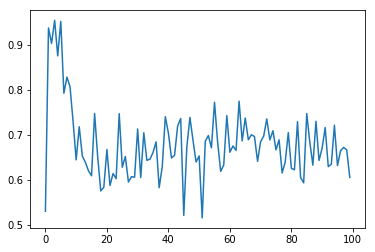

In [14]:
plt.plot(gen_loss)
plt.show()

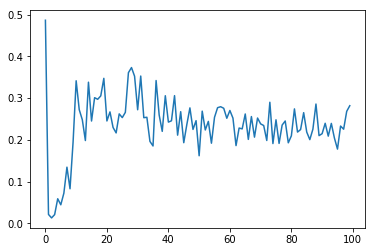

In [15]:
plt.plot(dis_loss)
plt.show()